In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.fftpack import fft,ifft
from scipy.io import wavfile
from scipy.signal import spectrogram
import IPython
from estimation import*
% matplotlib inline

# Récupération du signal audio

In [2]:
Fs,X = wavfile.read('data/a_montant.wav')
X = np.float64(X)
T = len(X)
print(Fs)
# spectrogramme 
Nfft = 2**7
f,t,spec = spectrogram(X,nfft=Nfft,nperseg=Nfft/2)

8000


C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


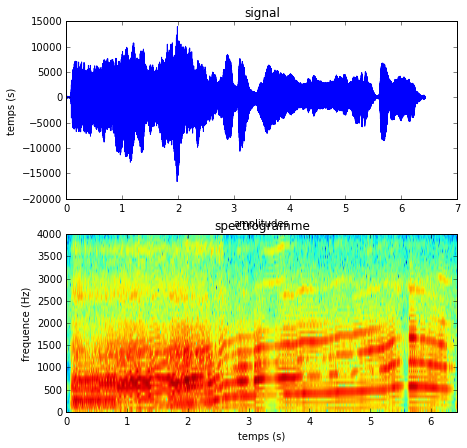

In [3]:
fig,ax = plt.subplots(2,1,figsize=(7,7))
ax[0].plot(np.arange(T)/Fs,X)
ax[0].set_title("signal")
ax[0].set_xlabel("amplitudes")
ax[0].set_ylabel("temps (s)")

ax[1].imshow(20*np.log10(spec[0:Nfft/2,:]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
ax[1].set_title("spectrogramme")
ax[1].set_xlabel("temps (s)")
ax[1].set_ylabel("frequence (Hz)")

IPython.display.Audio(X, rate=Fs)

# Estimateur

In [4]:
mu = 0.1
d = 20
X_est, theta_est = generation_est2(X, d, T, mu)

(51456,) (20, 51456)


C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


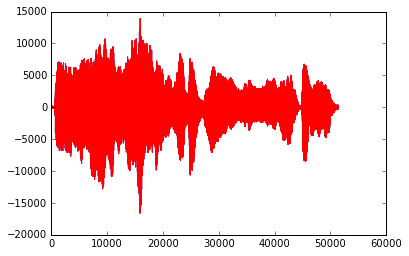

In [5]:
plt.plot(X)
plt.plot(X_est,'r')

print(X_est.shape,theta_est.shape)

# Analyse spectrale

In [6]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -theta_est #polynome caractértistique

freq, dsp_X_est = dsp(coeffs_est, T, Nfft)

print(dsp_X_est.shape)

(128, 51456)


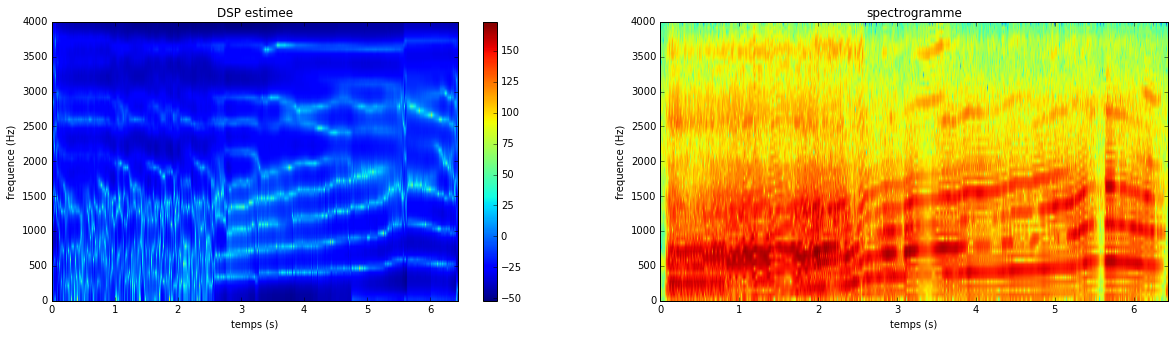

In [7]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
im=ax[0].imshow(20*np.log10(dsp_X_est[:Nfft/2,:]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("temps (s)")
ax[0].set_ylabel("frequence (Hz)")
ax[0].set_title("DSP estimee")
    
ax[1].imshow(20*np.log10(spec),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
ax[1].set_title("spectrogramme")
ax[1].set_xlabel("temps (s)")
ax[1].set_ylabel("frequence (Hz)")

plt.show()

#### Agrégation 

In [8]:
log_mu = np.arange(-3, -2, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)

pred, estim = do_aggregation(X,d,T, 0.1, mu,1)
pred2, estim2 = do_aggregation(X, d, T, 0.1, mu,2)

NameError: name 'pred_agr' is not defined

In [ ]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -estim

coeffs_est2 = np.ones((d+1,T),dtype='complex')
coeffs_est2[1:,:] = -estim2

f, dsp_X_est = dsp(coeffs_est, T, Nfft)
f, dsp_X_est2 = dsp(coeffs_est2, T, Nfft)


fig,ax = plt.subplots(1,3,figsize=(30,10))
fsize=18
    
ax[0].imshow(20*np.log10(spec),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
ax[0].set_title("spectrogramme", fontsize=fsize+2)
ax[0].set_xlabel("temps (s)", fontsize=fsize)
ax[0].set_ylabel("frequence (Hz)",fontsize=fsize)

im2=ax[1].imshow(20*np.log10(dsp_X_est[:Nfft/2]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("temps (s)",fontsize=fsize)
ax[1].set_ylabel("frequence (Hz)",fontsize=fsize)
ax[1].set_title("DSP estimee, strategie 1",fontsize=fsize+2)

im2=ax[2].imshow(20*np.log10(dsp_X_est2[:Nfft/2]),origin="lower", aspect="auto",extent=[0,(T-1)/Fs,0,Fs/2])
plt.colorbar(im2,ax=ax[2])
ax[2].set_xlabel("temps (s)",fontsize=fsize)
ax[2].set_ylabel("frequence (Hz)",fontsize=fsize)
ax[2].set_title("DSP estimee, strategie 2",fontsize=fsize+2)

plt.show()